In [7]:
from scm.csm import StructuralCausalModel, \
    linear_model, logistic_model

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional
import pandas as pd

In [8]:
def gaussian_mixture(n_samples: int, means: list, stds: list, weights: Optional[list] = None) -> np.ndarray:
    """
    Generate a Gaussian mixture distribution with the given means, standard deviations and weights.
    """
    if weights is None:
        weights = [1/len(means)] * len(means)
    assert len(means) == len(stds) == len(weights)
    n_components = len(means)
    components = [np.random.normal(loc=means[i], scale=stds[i], size=int(n_samples * weights[i])) for i in range(n_components)]
    return np.concatenate(components)

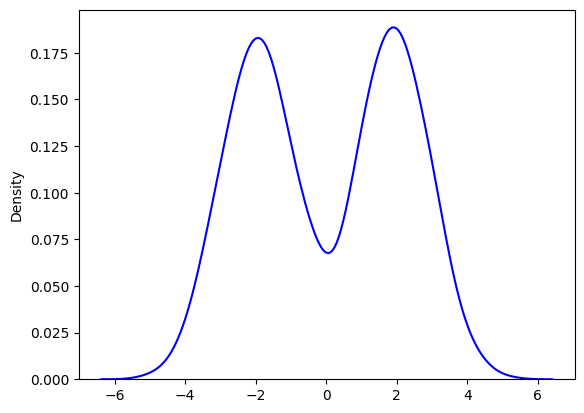

(5000,)


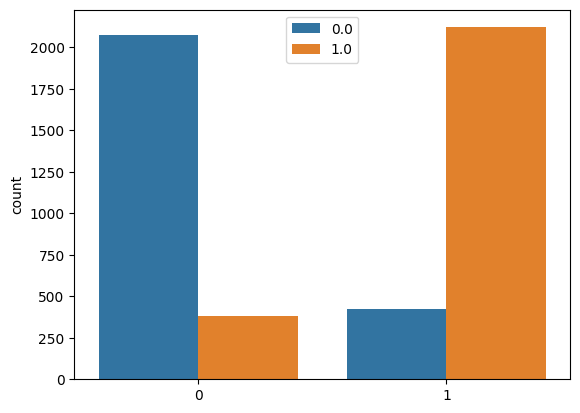

0.839


In [9]:
n_samples = 5000

mixture_data = gaussian_mixture(n_samples=n_samples, means=[-1.95, 1.95], stds=[1.0, 1.0], weights=None)

sns.kdeplot(mixture_data, color='blue')
plt.show()

# sample binomial from mixture data
binomial_data = np.random.binomial(1, 1/(1 + np.exp(-mixture_data)))
initial_label = np.concatenate([np.zeros(int(n_samples/2)), np.ones(int(n_samples/2))])

print(initial_label.shape)
# plot the binomial data per initial label
sns.countplot(x=binomial_data, hue=initial_label)
plt.show()

# print unaligned proportions
print(np.mean((binomial_data == initial_label).astype(int)))

<Axes: ylabel='count'>

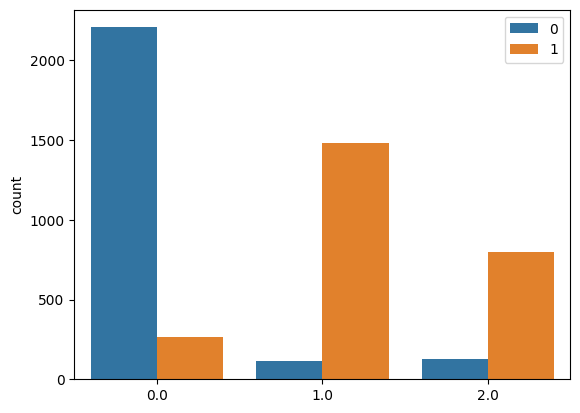

In [10]:
def sample_site_conditionally_on_binary_data(binomial_data: np.ndarray):
    n_samples = len(binomial_data)
    site = np.zeros(n_samples)
    for i in range(n_samples):
        if binomial_data[i] == 0:
            site[i] = np.random.choice([0, 1, 2], p=[0.9, 0.05, 0.05])
        else:
            site[i] = np.random.choice([0, 1, 2], p=[0.1, 0.6, 0.3])
    return site

site = sample_site_conditionally_on_binary_data(binomial_data)

# plot the site data per initial label
sns.countplot(x=site, hue=binomial_data)

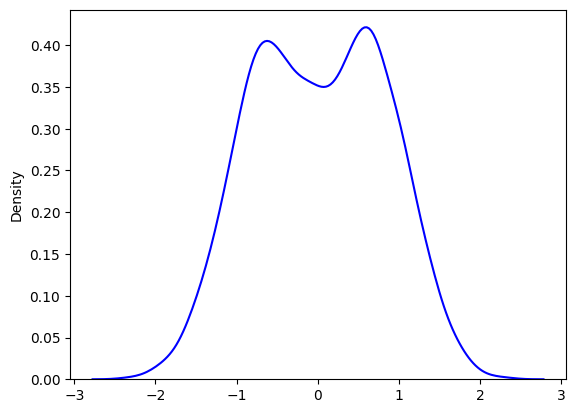

In [11]:
def sample_age_conditionally_on_binary_data(binomial_data: np.ndarray):
    n_samples = len(binomial_data)
    age = np.zeros(n_samples)
    for i in range(n_samples):
        if binomial_data[i] == 0:
            age[i] = np.random.normal(loc=-0.65, scale=0.5)
        else:
            age[i] = np.random.normal(loc=0.65, scale=0.5)
    return age

age = sample_age_conditionally_on_binary_data(binomial_data)

# plot the age data per initial label
sns.kdeplot(age, color='blue')
plt.show()

In [12]:
# predict the binomial_data from site and initial_label with a logistic regression model
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

site_onehot = np.eye(3)[np.int64(site)]
X = np.concatenate([site_onehot, initial_label[:, np.newaxis], age[:, np.newaxis]], axis=1)
y = binomial_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
# print(result.summary())

y_pred = result.predict(X_test)
y_pred = np.round(y_pred)
print(f"all features: {accuracy_score(y_test, y_pred)}")

# predict without site
X = np.concatenate([initial_label[:, np.newaxis], age[:, np.newaxis]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
# print(result.summary())

y_pred = result.predict(X_test)
y_pred = np.round(y_pred)
print(f"without site: {accuracy_score(y_test, y_pred)}")

# predict without age
X = np.concatenate([site_onehot, initial_label[:, np.newaxis]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
# print(result.summary())

y_pred = result.predict(X_test)
y_pred = np.round(y_pred)
print(f"without age: {accuracy_score(y_test, y_pred)}")

# predict without initial_label
X = np.concatenate([site_onehot, age[:, np.newaxis]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
# print(result.summary())

y_pred = result.predict(X_test)
y_pred = np.round(y_pred)
print(f"without initial_label: {accuracy_score(y_test, y_pred)}")

# site only
X = site_onehot
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

y_pred = result.predict(X_test)
y_pred = np.round(y_pred)
print(f"only site: {accuracy_score(y_test, y_pred)}")


# age only
X = age[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

y_pred = result.predict(X_test)
y_pred = np.round(y_pred)
print(f"only age: {accuracy_score(y_test, y_pred)}")

# initial_label only
X = initial_label[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

y_pred = result.predict(X_test)
y_pred = np.round(y_pred)
print(f"only initial_label: {accuracy_score(y_test, y_pred)}")


Optimization terminated successfully.
         Current function value: 0.080762
         Iterations 10
all features: 0.972
Optimization terminated successfully.
         Current function value: 0.188005
         Iterations 9
without site: 0.923
Optimization terminated successfully.
         Current function value: 0.227024
         Iterations 8
without age: 0.898
Optimization terminated successfully.
         Current function value: 0.118240
         Iterations 9
without initial_label: 0.957
Optimization terminated successfully.
         Current function value: 0.327332
         Iterations 7
only site: 0.898
Optimization terminated successfully.
         Current function value: 0.226794
         Iterations 8
only age: 0.905
Optimization terminated successfully.
         Current function value: 0.557059
         Iterations 6
only initial_label: 0.835


In [13]:
samples = {"Age": age, "Sex": binomial_data, "Site": site, "Age_true": age, "Sex_true": np.int64(initial_label), "Site_true": site}
samples = pd.DataFrame(samples)

In [14]:
# re-arange the columns to Age, Sex, Site and leave out the rest
# also add eid column, and assign a unique id running from 1 to n_samples
samples["eid"] = np.arange(1, len(samples) + 1)
samples = samples[["eid","Age", "Sex", "Site", "Age_true", "Sex_true", "Site_true"]]

# de-standardize the Age column (age - 63.709) / 7.519
samples["Age"] = samples["Age"] * 7.519 + 63.709
samples["Age"] = samples["Age"].round().astype(int)
samples["Age_true"] = samples["Age"]

# map site back, such that it reverses SITE_MAP = {11025: 0., 11026: 1., 11027: 2.}
SITE_MAP = {0: 11025, 1: 11026, 2: 11027}
samples["Site"] = samples["Site"].map(SITE_MAP)
samples["Site_true"] = samples["Site_true"].map(SITE_MAP)

In [15]:
samples.head()

,eid,Age,Sex,Site,Age_true,Sex_true,Site_true
0,1,65,0,11025,65,0,11025
1,2,61,0,11025,61,0,11025
2,3,59,0,11025,59,0,11025
3,4,55,0,11025,55,0,11025
4,5,60,0,11025,60,0,11025


<Axes: xlabel='Site', ylabel='count'>

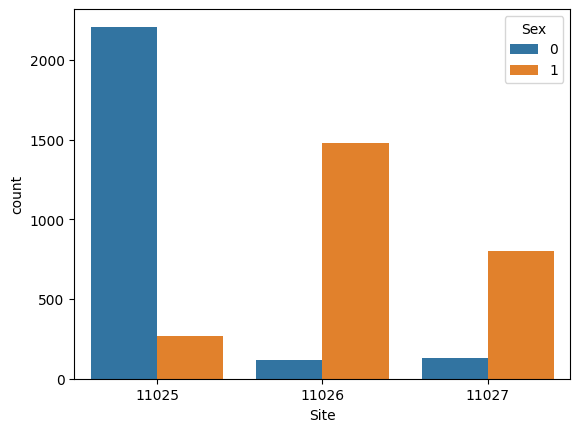

In [16]:
sns.countplot(x="Site", hue="Sex", data=samples)

<Axes: xlabel='Age', ylabel='Density'>

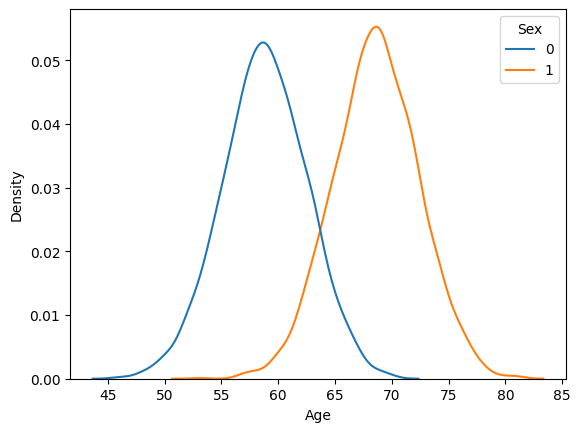

In [17]:
sns.kdeplot(data=samples, x="Age", hue="Sex")

<Axes: xlabel='Age', ylabel='Density'>

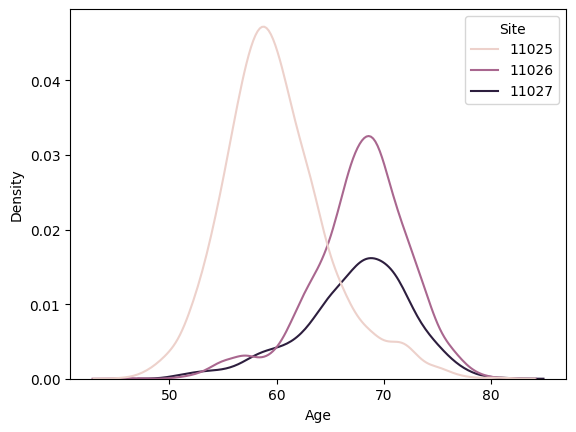

In [18]:
sns.kdeplot(data=samples, x="Age", hue="Site")

In [ ]:
samples.to_csv("mediation_experiment.csv", index=False)

In [20]:
samples.head()

,eid,Age,Sex,Site,Age_true,Sex_true,Site_true
0,1,65,0,11025,65,0,11025
1,2,61,0,11025,61,0,11025
2,3,59,0,11025,59,0,11025
3,4,55,0,11025,55,0,11025
4,5,60,0,11025,60,0,11025


In [147]:
samples.shape

(5000, 4)